In [1]:
import time
import warnings
import pickle
import shap

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb # recommended version: 1.5.0

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from xgboost import plot_importance

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
# Reading of Excel
train_metadata = pd.read_csv('train_dataset.csv')
test_metadata = pd.read_csv('test_dataset.csv')

In [3]:
train_metadata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,isBot
0,0,0,0,-0.058996,-0.101765,-0.375390,-0.064435,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,1
1,0,0,0,-0.058509,-0.061982,-0.024002,-0.064274,1,-0.277500,0,-1.193893,0,-0.264936,-0.226362,0,1,0,0
2,0,0,1,-0.058917,-0.092427,-0.206857,-0.062335,1,0.094003,0,0.467797,0,-0.264936,-0.226362,0,1,1,0
3,0,0,1,-0.057353,0.078232,-0.321707,-0.059427,1,1.580014,0,0.098533,0,6.295222,-0.226362,1,1,1,0
4,0,0,1,-0.058873,-0.094191,-0.207697,-0.064112,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16226,0,1,1,0.183041,2.307269,0.000665,-0.002560,1,1.580014,1,0.652429,0,-0.264936,-0.226362,1,1,1,1
16227,0,0,1,-0.058544,-0.093461,-0.219648,-0.057004,1,-0.277500,0,1.390958,0,-0.264936,-0.226362,0,1,0,0
16228,0,0,1,-0.058863,-0.095256,-0.194927,-0.062820,1,1.208511,0,0.652429,0,-0.264936,-0.226362,0,1,1,0
16229,0,0,0,-0.058952,-0.071228,-0.375411,-0.064274,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,1


In [4]:
test_metadata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,isBot
0,0,0,1,-0.058983,-0.100670,-0.376092,-0.063789,1,0.094003,1,-0.086100,0,-0.264936,-0.226362,0,1,0,0
1,0,0,1,-0.058989,-0.103012,-0.357559,-0.063466,1,-0.277500,1,1.206326,0,-0.264936,-0.226362,0,1,1,0
2,0,0,1,-0.058999,-0.105992,-0.292224,-0.064435,1,1.208511,1,1.206326,0,-0.264936,-0.226362,0,1,1,0
3,0,0,1,-0.058434,-0.075790,-0.296583,-0.059750,1,-0.649002,0,1.390958,1,1.375103,-0.226362,0,1,1,0
4,0,0,0,-0.046815,-0.021621,2.165586,-0.013061,1,1.580014,1,-1.563157,0,1.375103,-0.226362,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,0,0,0,-0.058997,-0.100578,-0.375454,-0.064435,1,-0.649002,0,-0.455364,0,-0.264936,-0.226362,0,1,1,1
4054,0,0,1,-0.058892,-0.086253,-0.217617,-0.063789,1,-0.277500,0,-1.193893,0,-0.264936,-0.226362,0,1,0,0
4055,0,0,1,-0.058947,-0.084458,-0.365236,-0.062335,1,0.465506,0,0.098533,0,3.015143,-0.226362,0,1,0,0
4056,0,0,1,-0.058681,-0.097932,-0.282102,-0.020977,1,-1.020505,0,0.098533,0,-0.264936,-0.226362,0,1,1,1


In [5]:
x_train = train_metadata.drop(columns = "isBot")
x_test = test_metadata.drop(columns = "isBot")
y_train = train_metadata["isBot"]
y_test = test_metadata["isBot"]

# Models
1. Logistic Regression
2. Support Vector Classifier
3. Random Forest Classifier
4. Adaboost Classifer
5. XGBoost Classifier

## 02 Support Vector Machine
* Model (Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model (Grid Search)

In [6]:
svm_search = SVC()

grid_svc = {"kernel": ['poly', 'rbf', 'sigmoid'], 
            "degree": [1, 3, 8], 
            "gamma": ['scale', 'auto'], 
            "C": [0.1, 1, 10, 100]}

grid_search = GridSearchCV(estimator = svm_search,
                           param_grid = grid_svc,
                           scoring = 'f1',
                           n_jobs = -1,
                           cv = 5,
                           verbose = 2)

In [7]:
%%time

# Execute search
results_grid_svm = grid_search.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 21 s
Wall time: 47min 18s


In [8]:
print('Best Score: %s' % results_grid_svm.best_score_)
print('Best Hyperparameters: %s' % results_grid_svm.best_params_)

Best Score: 0.7640687731040078
Best Hyperparameters: {'C': 100, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [9]:
%%time

# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_svm.predict(x_test)

CPU times: total: 3.09 s
Wall time: 3.28 s


In [10]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

Accuracy: 0.8846722523410547
Log Loss: 3.9833123916181545
ROC AUC: 0.8350095997636983
F1-score: 0.7732558139534883
Precision: 0.8260869565217391
Recall: 0.726775956284153


### Model (Optimal Hyperparameters)

In [12]:
# Model (initialise the object based on parameters selected by grid search)
params_svm = results_grid_svm.best_params_

svm_classifier = SVC(C = params_svm["C"], 
                     degree = params_svm["degree"], 
                     gamma = params_svm["gamma"], 
                     kernel = params_svm["kernel"],
                     probability= True)

In [16]:
%%time

# Fit Model
svm_model = svm_classifier.fit(x_train, np.ravel(y_train))

CPU times: total: 1min 38s
Wall time: 1min 41s


In [17]:
%%time

# y_prediction for the best model
y_pred_optimal = svm_model.predict(x_test)

CPU times: total: 3.2 s
Wall time: 3.27 s


In [18]:
# Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal)
print(f'Classification Report: \n {report}')

Accuracy: 0.8846722523410547
Log Loss: 3.9833123916181545
ROC AUC: 0.8350095997636983
F1-score: 0.7732558139534883
Precision: 0.8260869565217391
Recall: 0.726775956284153
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      2960
           1       0.83      0.73      0.77      1098

    accuracy                           0.88      4058
   macro avg       0.86      0.84      0.85      4058
weighted avg       0.88      0.88      0.88      4058



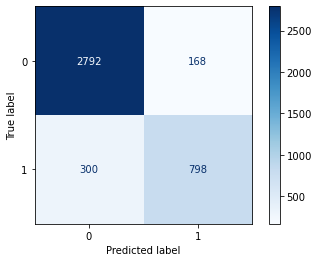

In [20]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(svm_model, x_test, y_test, cmap = "Blues")
plt.show()